## Advanced Machine Learning
### Practical 2 - Knowledge Distillation

In the last practical, we trained a model that was constrained by a small dataset. We improved its performance by exploiting another, larger dataset that provides useful signal on the same task.

In this practical, we will train a model that is constrained in size. We will then try to improve its performance by exploiting a larger model without this constraint that provides useful signal on the features it has learned.

The plan is as follows:

- We will first train our small model in the normal way, to establish a **baseline** performance for what is possible without a distillation. This is the **independent student** in the distillation setting.

- Second, we will train a large model on the same data. This should have a higher accuracy than the small model, since it is more powerful. This is the **teacher** model, which will imbue its knowledge into the student.

- Third, we will train a small model again, this time with response-based distillation from the teacher. This is the final **student** model. We hope this model will have higher performance than the independent student, ideally not far from that of the teacher.

We'll be implementing this scheme:
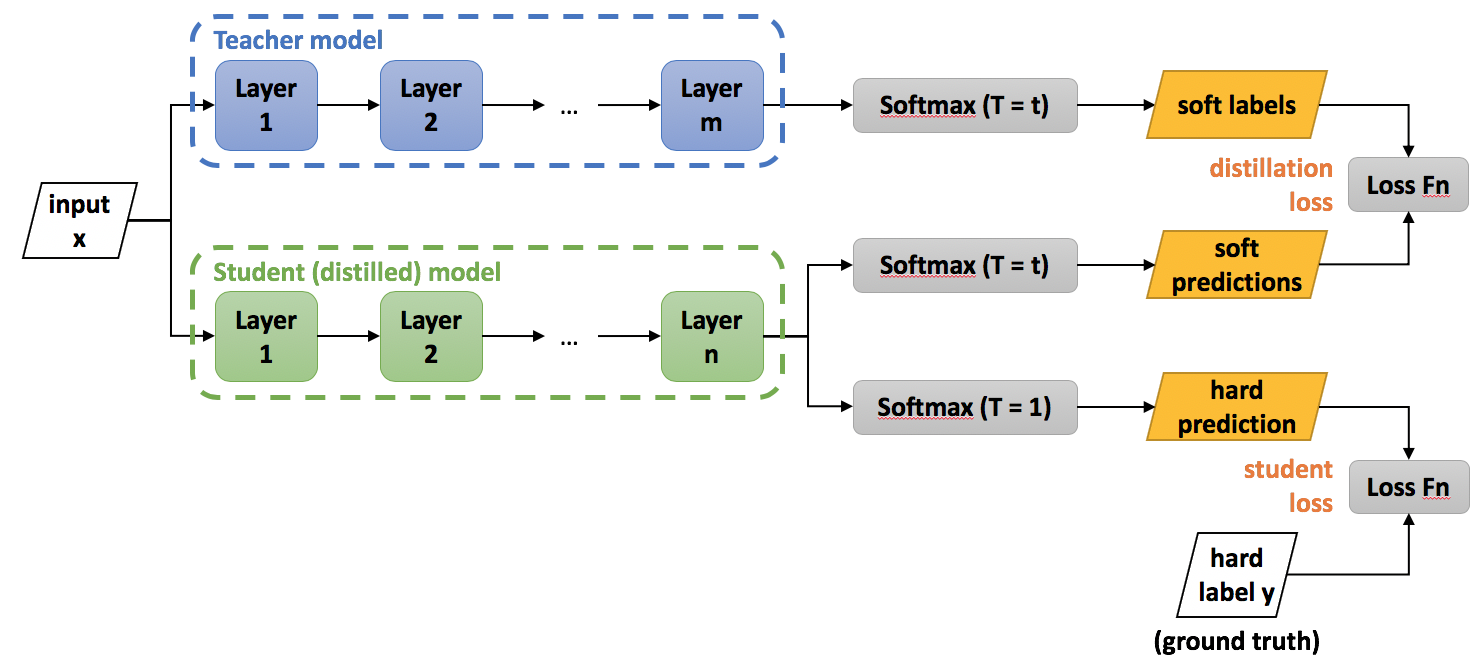


There are 3 tasks to complete in this notebook, which involve defining the distillation loss and creating the teacher-student training loop.



#### How to run this practical

If you don't have a GPU on your machine, you can download this notebook and upload it to [Kaggle](https://www.kaggle.com/code) or [Colab](https://colab.research.google.com/) to use their GPU resources. 
- You'll need to toggle on GPU acceleration in whichever one you use. On Kaggle you have to toggle on internet access as well.
- Kaggle seems to be much more reliable in practice, but use whatever works for you.

In [13]:
# set up the environment and install any missing packages:
!pip install torch torchvision numpy scipy matplotlib pandas pillow tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

## Data

For our dataset, we'll use CIFAR-10 again. It's small and reasonably fast to train on, but still complex enough to leave us a lot of performance ceiling.

In [14]:
### download the CIFAR-10 data:

cifar10 = datasets.CIFAR10(root='data/', download=True)
cifar10.name, cifar10.num_classes = 'CIFAR-10', len(cifar10.classes)
print(f'{cifar10.name}: {len(cifar10)} samples')
cifar10_labels = np.asarray([x[1] for x in cifar10])
cifar10_label_counts = np.unique(cifar10_labels, return_counts=True)[1]


print(' =Classes=')
for c, name in enumerate(cifar10.classes):
    num_samples = cifar10_label_counts[c]
    print(f'  {c}: {name:<10} ({num_samples} samples)')

### create a training/validation split:

VAL_FRAC = 0.1
num_val = int(len(cifar10) * VAL_FRAC)
num_train = len(cifar10) - num_val

torch.manual_seed(0)
# data_train, data_val = torch.utils.data.random_split(cifar10, [1-VAL_FRAC, VAL_FRAC])
data_train, data_val = torch.utils.data.random_split(cifar10, [num_train, num_val])

for split, name in zip([data_train, data_val],
                       ['train', 'validation']):
    print(f'{name} split: {len(split)} examples')



Files already downloaded and verified
CIFAR-10: 50000 samples
 =Classes=
  0: airplane   (5000 samples)
  1: automobile (5000 samples)
  2: bird       (5000 samples)
  3: cat        (5000 samples)
  4: deer       (5000 samples)
  5: dog        (5000 samples)
  6: frog       (5000 samples)
  7: horse      (5000 samples)
  8: ship       (5000 samples)
  9: truck      (5000 samples)
train split: 45000 examples
validation split: 5000 examples


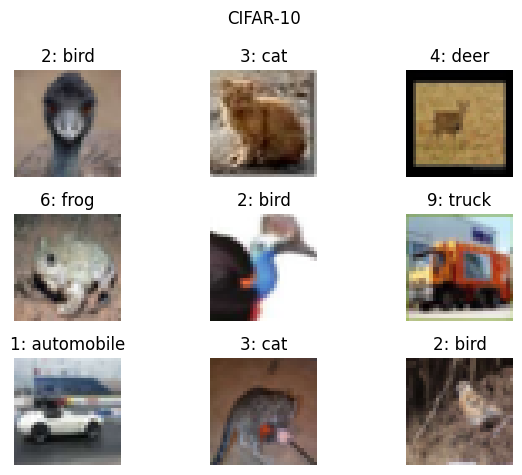

In [15]:

def inspect_data(data, layout=(3,3)):
    """accepts a training or validation subset
    and plots images from the data with class annotations"""
    num_examples = np.prod(layout)
    example_idxs = np.random.choice(range(len(data)), num_examples, replace=False)
    examples = [data[i] for i in example_idxs]

    # correct for label remapping:
    if 'remap' not in dir(data):
        original_set = data.dataset
    else:
        original_set = data

    # iterate through axes and plot individual examples:
    i = 0
    fig, axes = plt.subplots(*layout)
    for r, row in enumerate(axes):
        for c, ax in enumerate(row):
            image, label = examples[i]
            if 'classes' in dir(original_set):
                if 'remap' in dir(original_set):
                    label = original_set.remap[label]
                label = f'{label}: {original_set.classes[label]}'
            ax.imshow(image)
            # tidy up axis:
            ax.set_title(label)
            ax.set_axis_off()
            i += 1
    fig.suptitle(original_set.name)
    fig.tight_layout()
    
    plt.show()

inspect_data(data_train)

## Models

Here we define a model class that we'll use to construct both the student and teacher models. This one lets us specify the size and number of backbone convolutional layers:

In [16]:
class BasicCNN(nn.Module):
    def __init__(self, 
                 layers: list[int], # list of conv layer num_kernels
                 num_classes=10, # for CIFAR-10
                 input_size=(3,32,32), # for RGB images
                ):
        super().__init__()

        in_channels, in_h, in_w = input_size        

        # build convolutional backbone:
        conv_layers = []
        prev_layer_size = in_channels
        for layer_size in layers:
            conv_layers.append(nn.Conv2d(prev_layer_size, layer_size, (3,3), padding='same'))
            conv_layers.append(nn.ReLU())
            prev_layer_size = layer_size

        self.conv_stack = torch.nn.Sequential(*conv_layers)
        
        # downsampling to 4x4 spatial dim:
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.num_features = 4 * 4 * prev_layer_size
        
        self.fc1 = nn.Linear(self.num_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.classifier = nn.Linear(32, num_classes)

        self.relu = nn.ReLU()

        print(f'\nInitialised BasicCNN model with layers: {layers} and {self.num_parameters:,} parameters:\n{self}\n')
    
    def forward(self, x):
        # pass through conv layers:
        x = self.conv_stack(x)
        
        # downsample and reshape to vector:
        x = self.pool(x)
        x = x.view(-1, self.num_features)

        # final dense layers and classification head:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.classifier(x)

        return x

    @property
    def num_parameters(self):
        return sum([param.numel() for param in self.parameters()])


## Baseline Training

Below are some helper functions for model training, include a loop to simply train a model object with some chosen hyperparameters. For now it'll work unmodified to train our baseline models, but you'll need to modify it for distillation later.

In [17]:
### plotting and accuracy

def training_plot(metrics, 
      title=None, # optional figure title
      alpha=0.05, # smoothing parameter for train loss
      baselines=None, # optional list, or named dict, of baseline accuracies to compare to
      ):

    train_losses, val_losses, train_accs, val_accs, epoch_steps = metrics
    
    fig, (loss_ax, acc_ax) = plt.subplots(1,2)
    
    ### plot loss:
    smooth_train_loss = pd.Series(train_losses).ewm(alpha=alpha).mean()
    steps = np.arange(0, len(train_losses))

    # train loss is plotted at every step:
    loss_ax.plot(steps, smooth_train_loss, 'b-', label='train loss')
    # but val loss is plotted at every epoch:
    loss_ax.plot(epoch_steps, val_losses, 'r-', label='val loss')
    
    loss_ax.legend(); loss_ax.set_xlabel('Training step'); loss_ax.set_ylabel('Loss (CXE)')


    ### plot acc:
    smooth_train_acc = pd.Series(train_accs).ewm(alpha=0.05).mean()
    
    acc_ax.plot(steps, smooth_train_acc, 'b-', label='train acc')
    acc_ax.plot(epoch_steps, val_accs, 'r-', label='val acc')
    
    acc_ax.legend(); acc_ax.set_xlabel('Training step'); acc_ax.set_ylabel('Accuracy')

    # format as percentage on right:
    acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    acc_ax.yaxis.tick_right()
    acc_ax.yaxis.set_label_position('right')

    # optionally, draw lines at baseline accuracy points:
    if baselines is not None:
        if type(baselines) is list:
            for height in baselines:
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
            # rescale y-axis to accommodate baselines if needed:
            plt.ylim([0, max(list(smooth_train_acc) + val_accs + baselines)+0.05])                
        elif type(baselines) is dict:
            for name, height in baselines.items():
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
                # add text label as well:
                acc_ax.text(0, height+0.002, name, c=[0.6]*3, size=8)
            plt.ylim([0, max(list(smooth_train_acc) + val_accs + [h for h in baselines.values()])+0.05])                  

    
    plt.title(title)
    plt.tight_layout()
    plt.show()

def get_batch_acc(pred, y):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()

In [18]:
### simple model training loop:

def train_model(model, 
                train_loader,
                val_loader,
                num_epochs, 
                lr,  # initial learning rate
                l2_reg=0, # L2 weight decay term (0 means no regularisation)
                gamma=1, # exponential LR decay term (1 means no scheduling)
                baselines=None,
               ):
    
    # define loss and optimiser:
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)

    # learning rate scheduler:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=gamma)
    
    # track metrics for plotting training curves:
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    epoch_steps = [] # used for plotting val loss at the correct x-position
    metrics = [train_losses, val_losses, train_accs, val_accs, epoch_steps]
    best_val_acc = 0
    
    steps_trained = 0
    for e in range(num_epochs):
        train_bar = tqdm(train_loader, ncols=100)
        epoch_train_losses, epoch_train_accs = [], []
        for batch in train_bar:
            x, y = batch
            x, y = x.to(device), y.to(device)
    
            opt.zero_grad()
            
            pred = model(x)
            batch_loss = loss_func(pred, y)
            batch_acc = get_batch_acc(pred, y)
    
            batch_loss.backward()
            opt.step()
    
            # track loss and accuracy:
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accs.append(batch_acc)        
            steps_trained += 1

            train_bar.set_description(f'E{e} loss: {batch_loss:.2f} | acc: {batch_acc:.1%}')
        
        epoch_steps.append(steps_trained)
        scheduler.step()
    
        # record training metrics, by batch and over the epoch:
        train_losses.extend(epoch_train_losses)
        train_accs.extend(epoch_train_accs)

        print(f'train loss: {np.mean(epoch_train_losses):.2f}, train acc: {np.mean(epoch_train_accs):.1%}', end=' | ')
        
        # evaluate after each epoch::
        with torch.no_grad():
            batch_val_losses, batch_val_accs = [], []
    
            for batch in val_loader:
                vx, vy = batch
                vx, vy = vx.to(device), vy.to(device)
                
                vpred = model(vx)
                val_loss = loss_func(vpred, vy)
                val_acc = get_batch_acc(vpred, vy)
                
                batch_val_losses.append(val_loss.item())
                batch_val_accs.append(val_acc)
            val_losses.append(np.mean(batch_val_losses))
            val_accs.append(np.mean(batch_val_accs))

            # update best accuracy:
            if val_accs[-1] > best_val_acc:
                best_val_acc = val_accs[-1]

        print(f'val loss: {np.mean(batch_val_losses):.2f}, val acc: {np.mean(batch_val_accs):.1%}')
    
    
    
    # plot training curves:
    training_plot(metrics, baselines=baselines)

    print(f'Best validation accuracy: {best_val_acc:.2%}')
    return best_val_acc

### set up preprocessing and data loaders:
pre_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])
def collate(batch):
    images = [b[0] for b in batch]
    labels = [b[1] for b in batch]
    
    image_tensor = torch.stack([pre_transform(img) for img in images])
    label_tensor = torch.tensor(labels, dtype=torch.long)
    
    return image_tensor, label_tensor

train_loader, val_loader = [torch.utils.data.DataLoader(
                            data,
                            batch_size=256,
                            collate_fn=collate,
                            shuffle=True)
                        for data in (data_train, data_val)]

Now we train the two models. Remember, the performance of the independent student is our baseline of what's possible without distillation. This is what we will compare our final result to.

Training the teacher model takes a while (but we want a really good teacher to distil from). Note that it has 9x the parameters of the student.


Initialised BasicCNN model with layers: [32, 32, 16] and 33,626 parameters:
BasicCNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
  )
  (pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)


Initialised BasicCNN model with layers: [128, 128, 64, 32] and 278,666 parameters:
BasicCNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1

E0 loss: 1.57 | acc: 43.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 39.41it/s]


train loss: 1.79, train acc: 35.0% | val loss: 1.52, val acc: 44.0%


E1 loss: 1.36 | acc: 51.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 37.82it/s]


train loss: 1.43, train acc: 47.7% | val loss: 1.39, val acc: 49.9%


E2 loss: 1.31 | acc: 50.5%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 39.40it/s]


train loss: 1.29, train acc: 53.0% | val loss: 1.26, val acc: 55.2%


E3 loss: 1.24 | acc: 56.5%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 39.43it/s]


train loss: 1.19, train acc: 57.0% | val loss: 1.21, val acc: 56.1%


E4 loss: 1.01 | acc: 63.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 39.38it/s]


train loss: 1.13, train acc: 59.5% | val loss: 1.15, val acc: 58.5%


E5 loss: 1.07 | acc: 60.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 38.55it/s]


train loss: 1.07, train acc: 61.5% | val loss: 1.10, val acc: 61.0%


E6 loss: 1.04 | acc: 65.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 40.42it/s]


train loss: 1.03, train acc: 63.0% | val loss: 1.08, val acc: 62.3%


E7 loss: 1.05 | acc: 63.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 38.51it/s]


train loss: 0.99, train acc: 64.5% | val loss: 1.04, val acc: 63.1%


E8 loss: 1.03 | acc: 67.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 38.59it/s]


train loss: 0.96, train acc: 65.6% | val loss: 1.02, val acc: 64.0%


E9 loss: 0.96 | acc: 68.0%: 100%|█████████████████████████████████| 176/176 [00:04<00:00, 38.72it/s]


train loss: 0.93, train acc: 66.7% | val loss: 1.00, val acc: 65.1%


E10 loss: 0.83 | acc: 68.5%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 39.04it/s]


train loss: 0.91, train acc: 67.6% | val loss: 0.98, val acc: 65.4%


E11 loss: 0.94 | acc: 66.5%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 39.54it/s]


train loss: 0.89, train acc: 68.1% | val loss: 0.96, val acc: 66.5%


E12 loss: 1.03 | acc: 64.5%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 39.20it/s]


train loss: 0.87, train acc: 68.9% | val loss: 0.96, val acc: 66.7%


E13 loss: 0.89 | acc: 69.0%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 38.41it/s]


train loss: 0.86, train acc: 69.3% | val loss: 0.97, val acc: 66.3%


E14 loss: 0.77 | acc: 72.0%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 39.59it/s]


train loss: 0.84, train acc: 70.0% | val loss: 0.93, val acc: 68.1%


E15 loss: 0.79 | acc: 74.0%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 39.76it/s]


train loss: 0.83, train acc: 70.6% | val loss: 0.93, val acc: 67.6%


E16 loss: 0.70 | acc: 74.0%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 38.97it/s]


train loss: 0.82, train acc: 70.9% | val loss: 0.93, val acc: 67.4%


E17 loss: 0.81 | acc: 70.5%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 38.97it/s]


train loss: 0.81, train acc: 71.3% | val loss: 0.91, val acc: 68.1%


E18 loss: 0.82 | acc: 72.5%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 38.81it/s]


train loss: 0.80, train acc: 71.5% | val loss: 0.91, val acc: 69.0%


E19 loss: 0.76 | acc: 72.0%: 100%|████████████████████████████████| 176/176 [00:04<00:00, 39.00it/s]


train loss: 0.79, train acc: 71.8% | val loss: 0.91, val acc: 68.9%


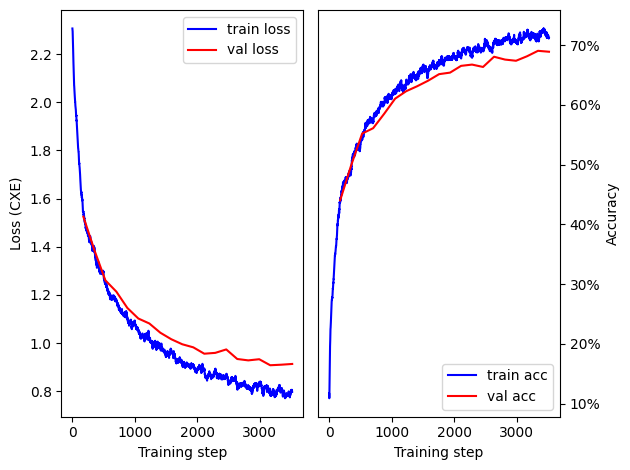

Best validation accuracy: 69.05%

Training teacher model:


E0 loss: 1.49 | acc: 42.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 13.74it/s]


train loss: 1.83, train acc: 31.8% | val loss: 1.54, val acc: 43.3%


E1 loss: 1.41 | acc: 52.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.07it/s]


train loss: 1.45, train acc: 47.0% | val loss: 1.39, val acc: 50.2%


E2 loss: 1.10 | acc: 57.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 13.84it/s]


train loss: 1.28, train acc: 53.7% | val loss: 1.22, val acc: 56.5%


E3 loss: 1.07 | acc: 66.5%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.17it/s]


train loss: 1.16, train acc: 58.5% | val loss: 1.16, val acc: 58.9%


E4 loss: 1.24 | acc: 54.5%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.05it/s]


train loss: 1.06, train acc: 62.1% | val loss: 1.07, val acc: 62.1%


E5 loss: 1.00 | acc: 60.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.21it/s]


train loss: 1.00, train acc: 64.4% | val loss: 1.06, val acc: 62.0%


E6 loss: 1.13 | acc: 58.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.10it/s]


train loss: 0.93, train acc: 66.8% | val loss: 1.00, val acc: 64.6%


E7 loss: 0.94 | acc: 67.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.14it/s]


train loss: 0.88, train acc: 68.4% | val loss: 0.94, val acc: 67.5%


E8 loss: 0.87 | acc: 66.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 13.98it/s]


train loss: 0.84, train acc: 70.0% | val loss: 0.92, val acc: 67.7%


E9 loss: 0.78 | acc: 72.5%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.15it/s]


train loss: 0.81, train acc: 71.4% | val loss: 0.90, val acc: 68.9%


E10 loss: 0.64 | acc: 76.0%: 100%|████████████████████████████████| 176/176 [00:12<00:00, 13.94it/s]


train loss: 0.78, train acc: 72.2% | val loss: 0.89, val acc: 70.2%


E11 loss: 0.73 | acc: 73.0%: 100%|████████████████████████████████| 176/176 [00:12<00:00, 13.99it/s]


train loss: 0.75, train acc: 73.2% | val loss: 0.85, val acc: 71.0%


E12 loss: 0.81 | acc: 69.5%: 100%|████████████████████████████████| 176/176 [00:13<00:00, 13.49it/s]


train loss: 0.73, train acc: 73.7% | val loss: 0.88, val acc: 70.3%


E13 loss: 0.71 | acc: 73.5%: 100%|████████████████████████████████| 176/176 [00:12<00:00, 13.72it/s]


train loss: 0.71, train acc: 74.6% | val loss: 0.83, val acc: 71.5%


E14 loss: 0.66 | acc: 79.0%: 100%|████████████████████████████████| 176/176 [00:12<00:00, 14.19it/s]


train loss: 0.70, train acc: 75.0% | val loss: 0.83, val acc: 71.1%


E15 loss: 0.73 | acc: 73.0%: 100%|████████████████████████████████| 176/176 [00:12<00:00, 14.06it/s]


train loss: 0.68, train acc: 75.7% | val loss: 0.82, val acc: 71.7%


E16 loss: 0.64 | acc: 75.0%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.91it/s]


train loss: 0.67, train acc: 76.1% | val loss: 0.79, val acc: 72.7%


E17 loss: 0.67 | acc: 75.0%: 100%|████████████████████████████████| 176/176 [00:10<00:00, 16.07it/s]


train loss: 0.65, train acc: 76.7% | val loss: 0.80, val acc: 73.0%


E18 loss: 0.79 | acc: 70.0%: 100%|████████████████████████████████| 176/176 [00:10<00:00, 16.25it/s]


train loss: 0.64, train acc: 77.1% | val loss: 0.80, val acc: 72.6%


E19 loss: 0.67 | acc: 73.0%: 100%|████████████████████████████████| 176/176 [00:10<00:00, 16.27it/s]


train loss: 0.63, train acc: 77.5% | val loss: 0.80, val acc: 72.3%


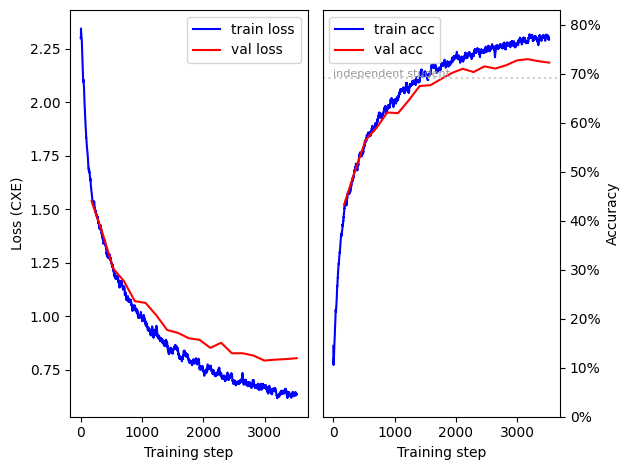

Best validation accuracy: 72.98%


In [19]:
### training hyperparameters

# define baseline models:
batch_size = 256
num_epochs = 20
lr = 5e-3 # initial learning rate
l2_reg = 1e-4 # L2 loss term
gamma = 0.9 # LR scheduling term

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define student and teacher models:

student_layers = [32,32,16] 
teacher_layers = [128,128,64,32] # deeper and much wider

ind_student = BasicCNN(student_layers).to(device)
teacher = BasicCNN(teacher_layers).to(device)


print(f'\nTraining independent student model:')
ind_student_acc = train_model(ind_student, train_loader, val_loader, 
                              num_epochs, lr, l2_reg, gamma) 
# on Kaggle, this one takes about 15s per epoch

print(f'\nTraining teacher model:')
teacher_acc = train_model(teacher, train_loader, val_loader, 
                          num_epochs, lr, l2_reg, gamma, 
                          baselines={'independent student': ind_student_acc})
# and this one about 22s per epoch

# so probably about 15 minutes overall

Now we have our trained teacher model, and our independent student for comparison. You should see that the student model gets around 64% validation accuracy, while the teacher is around 9-10% higher than that. 

We'll close that distance by imbuing the knowledge of the teacher into the student.

## Distillation

**Your task** is to improve the performance of the student model using output-based distillation. You'll initialise a new student model (with the same architecture as the independent student), and train it with the same hyperparameters, but with additional signal from the teacher.

The key component of this is defining the **distillation loss** that will be used during the training. Recall that this is the distance in the output distributions between the student and the teacher model. We'll use KL divergence as our distance measure.

### Output Logits

First, let's see what those output distributions look like. The code below pulls an example from the training data and shows:
- its one-hot **hard labels**;
- the teacher model's prediction,
  - given as **unscaled logits** directly from the network;
  - and after applying **softmax** to those logits.

Remember that our usual loss function `nn.CrossEntropyLoss` expects unscaled logits and applies a softmax internally. 

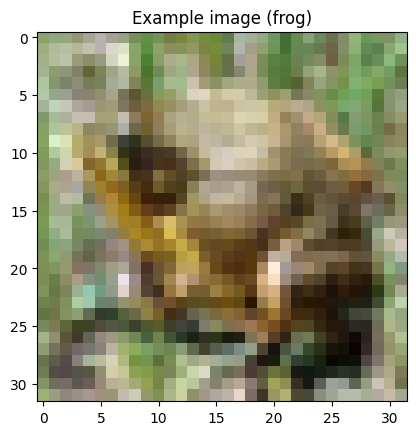

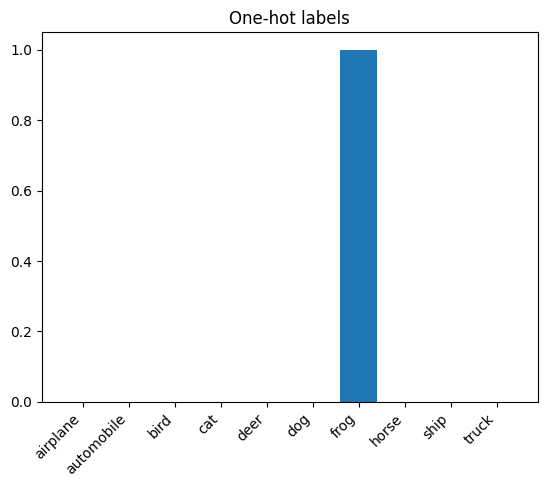

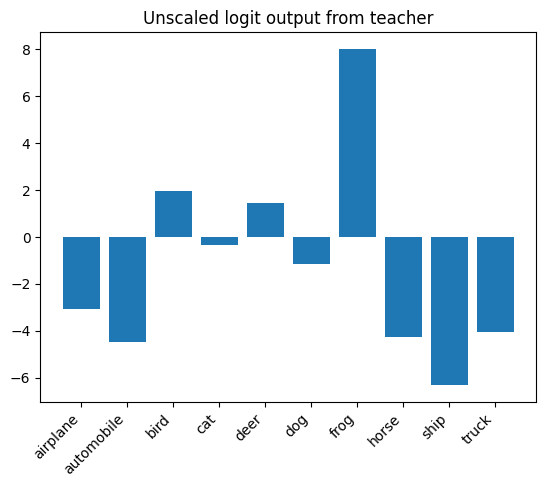

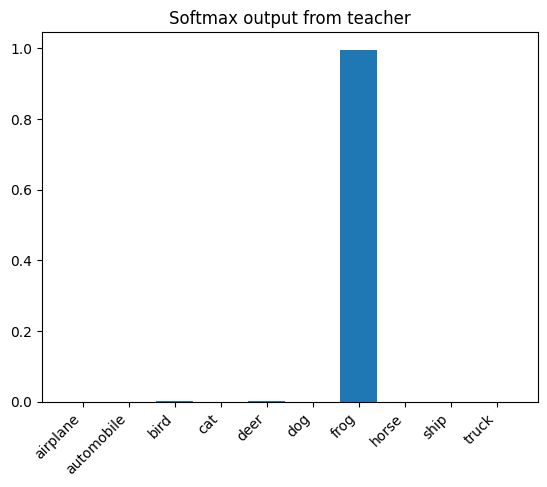

In [20]:
import torch.nn.functional as F

# get a batch of training data:
torch.manual_seed(1)
example_x, example_y = next(iter(train_loader))

# display the first image in the first example:
img = example_x[0].permute([1,2,0]) # rearrange to H*W*C
img = (img - img.min()) / (img.max() - img.min()) # un-normalise
plt.imshow(img)
plt.title(f'Example image ({cifar10.classes[example_y[0]]})')
plt.show()

# inspect its labels:
def plot_distribution(vector, title, num_classes=10):
    plt.bar(cifar10.classes, vector.detach().cpu().numpy())
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.show()

y_onehot = F.one_hot(example_y)
plot_distribution(y_onehot[0], title='One-hot labels')

# inspect the teacher's prediction on that example:
teacher_pred = teacher(example_x.to(device))
plot_distribution(teacher_pred[0], 'Unscaled logit output from teacher')

# and compare raw logits to the softmax probability distribution:
teacher_soft = torch.softmax(teacher_pred, dim=1)
plot_distribution(teacher_soft[0], 'Softmax output from teacher')

You can see that the softmax output is a probability distribution that is 'smoother' than the hard labels. 

The hard label just says 'frog'. The teacher's output gives a high probability to 'frog', but also that the object is more likely to be a 'bird' or a 'deer', than it is to be a 'ship' or a 'truck' - likely because images of animals share more features with other animals than they do with man-made objects. 

These are the subtle class boundaries that the teacher has learned, and it's the additional signal we will provide to the student in distillation.

However, as you can see from the last plot: since our teacher is very confident, the non-maximal probabilities are still very small, so it's not *very* different from just training on the hard labels.

To improve the distillation process, we'll use a **temperature** term to control the softness of this distribution. This gives the student more information to learn from. For temperature values over 1, this is sort of like label smoothing applied over the teacher's outputs.

# Task 1: Temperature-scaled Softmax

Complete the `temperature_softmax` function below. 
- It should accept a torch tensor `x` of shape `(batch, num_classes)`, representing the unscaled logits from a model's classification layer, and a temperature parameter `T`
- and return a torch tensor of shape `(batch, num_classes)` with a probability distribution over each example in the batch.

It should implement the formula:

$$y_i = \frac{exp(z_i / T)} {\sum_j exp(z_j / T)}$$  

<p style="text-align: center;">(for unscaled logits $z$ and temperature $T$)</p>



Note that the regular softmax formula is:

$$y_i = \frac{exp(z_i)} {\sum_j exp(z_j)}$$

so the `temperature_softmax` function is equivalent to regular softmax on logits rescaled by $T$.

The output you get should look something like this:

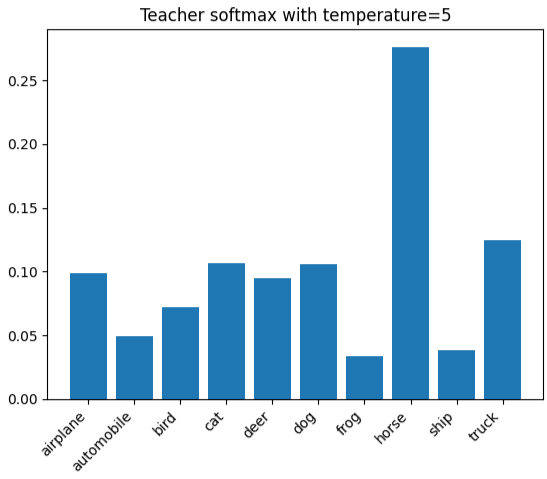

In [21]:
def temperature_softmax(x, T):
    """accepts unscaled logits from model output,
    and temperature parameter T,
    and returns temperature-scaled softmax distribution of those logits"""
    return torch.softmax(x / T, dim=1)


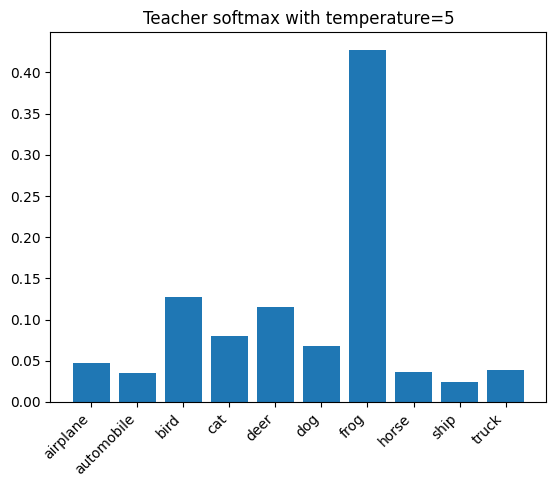

In [22]:
### plot the distribution to see if your function works:

temp = 5
teacher_soft_temp = temperature_softmax(teacher_pred, temp)

plot_distribution(teacher_soft_temp[0], f'Teacher softmax with temperature={temp}')
### these are the actual 'soft labels' we use to teach the student

# Task 2: Distillation Loss

Now you'll implement the distillation loss as the distance between the student and teacher outputs.

Apply temperature-scaled softmax to the logits from both models. Then, compute the distillation loss as the KL divergence between the two.

Finally, there's one more step. Since the gradients computed from soft targets are scaled down compared to those of hard targets, by a factor of $\frac{1}{T^2}$, you should compensate by multiplying the KL divergence term by $T^2$. This gives us the final value of the 'soft loss' we use in distillation.

Complete the `distillation_output_loss` function below. 
- It should accept torch tensors `student_pred` and `teacher_pred`, of shape `(batch, num_classes)`, representing the unscaled logits produced by the student and teacher models on some batch, and the temperature parameter. 
- It should return the KL-divergence between the temperature-scaled softmax distributions of the two prediction vectors as a torch float, averaged across the batch.


If you have temperature-scaled softmax outputs $y_s$ and $y_t$ for student and teacher, and with temperature $T$, your function should implement the formula:
$$
L_d = D_{KL}(y_s \parallel y_t) \: T^2
$$

**Note:** the built-in torch functions for KL divergence expect log-probability inputs (which is a little strange), so they won't work correctly out of the box. You can find a way around this, or write the KL divergence function yourself.

Recall that the KL divergence formula is:
$$
D_{KL}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

In [23]:
def distillation_output_loss(student_pred, teacher_pred, temperature):
    """accepts unscaled logits from student and teacher model,
    applies temperature-scaled softmax to both, 
    and returns distillation loss as the KL-divergence between them"""

    teacher_soft = temperature_softmax(teacher_pred, temperature)
    student_soft = temperature_softmax(student_pred, temperature)

    #Compute the KL divergence between the two distributions
    kl_div = torch.sum(teacher_soft * torch.log(teacher_soft / student_soft), dim=1)
    return kl_div.mean() * temperature**2
    

### test case:
student_pred = ind_student(example_x.to(device))
teacher_pred = teacher(example_x.to(device))


# calculate the normal XE loss for comparison:
hard_loss = nn.CrossEntropyLoss()(student_pred, example_y.to(device))

temp = 5
soft_loss = distillation_output_loss(student_pred, teacher_pred, temp) 

### sanity checks:
assert soft_loss.shape == (), f"Soft loss should be a single float averaged across the batch, like cross-entropy loss, but is: {soft_loss.shape}"

print(f"Hard loss between student's prediction and one-hot labels: {hard_loss:.4f}")
print(f"Soft loss (T={temp}) between student and teacher's predictions: {soft_loss:.4f}")

assert soft_loss > 0, f"Soft loss should not be negative: check your KL divergence!"

# they should be the same order of magnitude:
assert (0.1 < (hard_loss / soft_loss) < 10), f"Hard loss is too different from soft loss - make sure you're rescaling the divergence according to the temperature term."

print(f'+ Looks correct! +')

Hard loss between student's prediction and one-hot labels: 0.9241
Soft loss (T=5) between student and teacher's predictions: 1.2554
+ Looks correct! +


If your code works, it should pass the above sanity checks, and you'll see a value for the soft loss that is different to the hard loss but of similar scale.

Now, you have what you need to train a distilled student model. This is the final task.

# Task 3: Distillation Training

Below, we initialise a new student model. Your task is to train it with the same hyperparameters, except combining the original 'hard loss' with the soft loss from the function we've just defined.

Your objective is to beat the validation accuracy of the independent student baseline, which was around 10% below the teacher. See if you can get a boost of at least 5%!

#### Tips:

* Since the hard loss and soft loss have similar scales, if you add them together, you are doubling the size of the loss value - which means doubling the gradients used to update the model. You might want to average them instead of summing, or change your learning rate to compensate.

* Make sure you're not updating the weights of the teacher model. By default, pointing the optimiser at the student model's parameters is enough to achieve this. But you can avoid computing the teacher's gradients at all using `torch.no_grad` - this will make training much faster.

* As before, it's expected that you will need to look up some things, but avoid using AI assistants like ChatGPT to write your code for you. This is for your own good - you will learn more about the topic, and about ML engineering, if you implement it yourself.

* Be careful with namespace errors!


Initialised BasicCNN model with layers: [32, 32, 16] and 33,626 parameters:
BasicCNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
  )
  (pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)



E0 loss: 2.10 | acc: 46.5%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 13.99it/s]


train loss: 2.94, train acc: 35.9% | val loss: 1.62, val acc: 43.6%


E1 loss: 1.64 | acc: 56.0%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 13.86it/s]


train loss: 1.87, train acc: 49.5% | val loss: 1.37, val acc: 51.9%


E2 loss: 1.34 | acc: 61.5%: 100%|█████████████████████████████████| 176/176 [00:12<00:00, 14.66it/s]


train loss: 1.52, train acc: 55.0% | val loss: 1.35, val acc: 54.2%


E3 loss: 1.41 | acc: 55.5%: 100%|█████████████████████████████████| 176/176 [00:11<00:00, 15.10it/s]


train loss: 1.33, train acc: 59.0% | val loss: 1.21, val acc: 58.9%


E4 loss: 1.17 | acc: 64.5%: 100%|█████████████████████████████████| 176/176 [00:11<00:00, 15.13it/s]


train loss: 1.19, train acc: 61.6% | val loss: 1.15, val acc: 60.7%


E5 loss: 1.13 | acc: 57.5%: 100%|█████████████████████████████████| 176/176 [00:11<00:00, 15.13it/s]


train loss: 1.09, train acc: 63.4% | val loss: 1.08, val acc: 63.2%


E6 loss: 0.89 | acc: 70.5%: 100%|█████████████████████████████████| 176/176 [00:11<00:00, 15.14it/s]


train loss: 1.00, train acc: 65.1% | val loss: 1.03, val acc: 64.6%


E7 loss: 0.98 | acc: 65.5%: 100%|█████████████████████████████████| 176/176 [00:11<00:00, 15.10it/s]


train loss: 0.95, train acc: 66.1% | val loss: 1.03, val acc: 65.0%


E8 loss: 0.92 | acc: 66.5%: 100%|█████████████████████████████████| 176/176 [00:11<00:00, 15.03it/s]


train loss: 0.90, train acc: 67.3% | val loss: 0.98, val acc: 66.9%


E9 loss: 0.78 | acc: 73.5%: 100%|█████████████████████████████████| 176/176 [00:11<00:00, 15.14it/s]


train loss: 0.86, train acc: 68.1% | val loss: 0.97, val acc: 66.7%


E10 loss: 0.77 | acc: 67.0%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.13it/s]


train loss: 0.83, train acc: 68.8% | val loss: 0.94, val acc: 68.1%


E11 loss: 0.79 | acc: 68.0%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.11it/s]


train loss: 0.80, train acc: 69.4% | val loss: 0.93, val acc: 68.3%


E12 loss: 0.78 | acc: 69.5%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.06it/s]


train loss: 0.78, train acc: 69.7% | val loss: 0.92, val acc: 68.6%


E13 loss: 0.69 | acc: 74.5%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.17it/s]


train loss: 0.76, train acc: 70.5% | val loss: 0.91, val acc: 68.8%


E14 loss: 0.77 | acc: 71.0%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 14.97it/s]


train loss: 0.74, train acc: 70.5% | val loss: 0.92, val acc: 68.6%


E15 loss: 0.74 | acc: 71.0%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.11it/s]


train loss: 0.73, train acc: 71.0% | val loss: 0.90, val acc: 69.3%


E16 loss: 0.79 | acc: 62.0%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.20it/s]


train loss: 0.72, train acc: 71.5% | val loss: 0.91, val acc: 68.9%


E17 loss: 0.72 | acc: 68.5%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.21it/s]


train loss: 0.70, train acc: 71.6% | val loss: 0.88, val acc: 69.7%


E18 loss: 0.70 | acc: 69.5%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.17it/s]


train loss: 0.70, train acc: 71.9% | val loss: 0.88, val acc: 70.0%


E19 loss: 0.64 | acc: 77.5%: 100%|████████████████████████████████| 176/176 [00:11<00:00, 15.16it/s]


train loss: 0.69, train acc: 72.2% | val loss: 0.88, val acc: 70.3%
Best validation accuracy: 70.29%


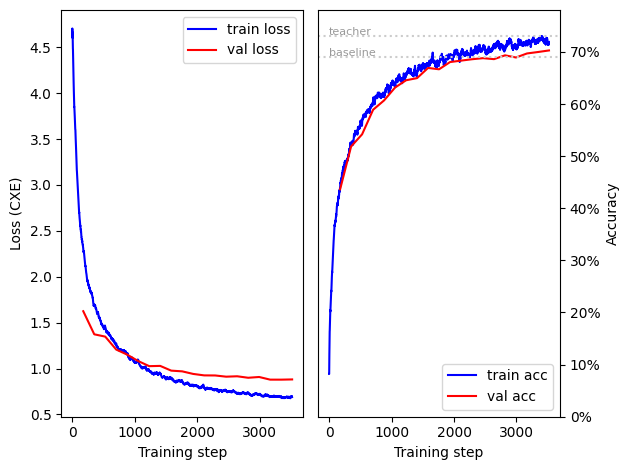

In [24]:
### DISTILLATION TRAINING

# we have one extra hyperparameter:
TEMPERATURE = 5
# you can experiment with it, but this is a good value.
# keep the other hyperparameters as before


# define distillation student model
# (with same architecture as independent student, for comparison)
student = BasicCNN(student_layers).to(device)


# track metrics for plotting training curves:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
epoch_steps = [] # used for plotting val loss at the correct x-position
metrics = [train_losses, val_losses, train_accs, val_accs, epoch_steps]


### your code here:
# define loss and optimiser:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(student.parameters(), lr=lr, weight_decay=l2_reg)

# learning rate scheduler:
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=gamma)

best_val_acc = 0
steps_trained = 0

for e in range(num_epochs):
    train_bar = tqdm(train_loader, ncols=100)
    epoch_train_losses, epoch_train_accs = [], []
    for batch in train_bar:
        x, y = batch
        x, y = x.to(device), y.to(device)

        opt.zero_grad()

        student_pred = student(x)
        teacher_pred = teacher(x)

        hard_loss = loss_func(student_pred, y)
        soft_loss = distillation_output_loss(student_pred, teacher_pred, TEMPERATURE)

        # combine losses (you can experiment with the weighting)
        loss = (hard_loss + soft_loss) / 2

        loss.backward()
        opt.step()

        # track loss and accuracy:
        epoch_train_losses.append(loss.item())
        epoch_train_accs.append(get_batch_acc(student_pred, y))
        steps_trained += 1

        train_bar.set_description(f'E{e} loss: {loss:.2f} | acc: {epoch_train_accs[-1]:.1%}')

    epoch_steps.append(steps_trained)
    scheduler.step()

    # record training metrics, by batch and over the epoch:
    train_losses.extend(epoch_train_losses)
    train_accs.extend(epoch_train_accs)

    print(f'train loss: {np.mean(epoch_train_losses):.2f}, train acc: {np.mean(epoch_train_accs):.1%}', end=' | ')

    # evaluate after each epoch::
    with torch.no_grad():
        batch_val_losses, batch_val_accs = [], []

        for batch in val_loader:
            vx, vy = batch
            vx, vy = vx.to(device), vy.to(device)

            vpred = student(vx)
            val_loss = loss_func(vpred, vy)
            val_acc = get_batch_acc(vpred, vy)

            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
        val_losses.append(np.mean(batch_val_losses))
        val_accs.append(np.mean(batch_val_accs))

        # update best accuracy:
        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]

    print(f'val loss: {np.mean(batch_val_losses):.2f}, val acc: {np.mean(batch_val_accs):.1%}')

print(f'Best validation accuracy: {best_val_acc:.2%}')

# plot training curves, showing the highest val accuracies of independent student and teacher models:
training_plot(metrics, baselines = {'baseline': ind_student_acc, 'teacher': teacher_acc})

### Assessment

* Report your results with **a plot or two** comparing the final validation accuracy of the distilled student model to the teacher and the independent student baseline.
    
* Also write **a few sentences** summarising any particular issues you ran into, how you solved them, and any insights you gained about the distillation process or its implementation.

Good luck! Contact me if you have any problems.